In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os, sys, camb
from camb import model, initialpower
from astropy import units as u, constants as c
from astropy.cosmology import Planck18 as cosmo
from scipy.interpolate import interp1d

import utils2 as ut
import props2 as p
import EuclidProps as Eu
import E_lines as l
from importlib import reload
reload(ut)
reload(p)
reload(l)
reload(Eu)

<module 'EuclidProps' from 'c:\\Users\\juzz\\Desktop\\TIM\\LIMxJuzz\\LIM\\TIMxGal\\EuclidProps.py'>

In [2]:
colors = ['purple', 'blue', 'gold', 'red']
linestyles = ['-','--',':','-.']

In [3]:
VanillaTIM = p.subSurveys
print('Redshift bins:', [(np.around(subSurvey.zBin.zFront.value, 2), np.around(subSurvey.zBin.zBack.value, 2))
                                for subSurvey in VanillaTIM])
print('Redshift bin anglular resolutions:', [(subSurvey.zBin.dOmega.to(u.sr).value) 
                                for subSurvey in VanillaTIM])
print('Noise per Voxel:', [subSurvey.cell_noise()for subSurvey in VanillaTIM])

Redshift bins: [(0.52, 0.76), (0.76, 1.01), (1.01, 1.33), (1.33, 1.66)]
Redshift bin anglular resolutions: [2.5009050306249995e-08, 3.298854875625e-08, 4.371340100624999e-08, 5.7836642556250006e-08]
Noise per Voxel: [<Quantity 8.77483995e+12 Mpc3 Jy2 / s2>, <Quantity 1.66482602e+13 Mpc3 Jy2 / s2>, <Quantity 9.90169413e+12 Mpc3 Jy2 / s2>, <Quantity 1.51812916e+13 Mpc3 Jy2 / s2>]


In [4]:
EuMinimal = Eu.subSurveys #
TIMxEu = [ut.LIMxGAL(TIMBin, EuBin, window = "Gaussian") for TIMBin, EuBin in zip(VanillaTIM, EuMinimal)]

Applying Gaussian windowing
sPar: 5.522480633096668 Mpc, sPerp: 0.10904845571736989, galPar: 3.451550395685418 Mpc
Applying Gaussian windowing
sPar: 6.285520716479786 Mpc, sPerp: 0.16170141502424165, galPar: 3.9284504477998663 Mpc
Applying Gaussian windowing
sPar: 5.291560807957791 Mpc, sPerp: 0.22805881740705583, galPar: 3.3072255049736192 Mpc
Applying Gaussian windowing
sPar: 5.856478551331577 Mpc, sPerp: 0.3087552358689265, galPar: 3.6602990945822356 Mpc


c:\Users\juzz\anaconda3\envs\simim\lib\site-packages\astropy\units\quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


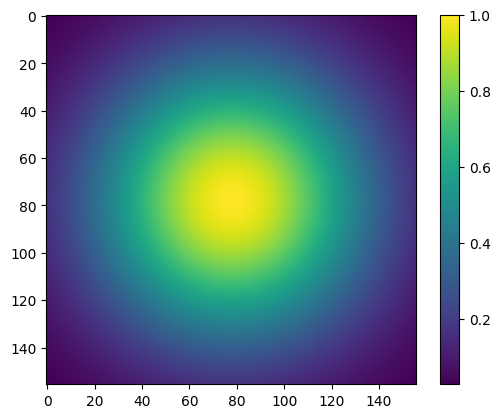

In [5]:
plt.figure()
#plt.imshow(TIMxEu[0].transferCoefs[:, :, 0])
plt.imshow(np.fft.fftshift(TIMxEu[0].transferCoefs[:, :, 0]).T ** 2)
plt.colorbar()
plt.show()
plt.close()

Note: redshifts have been re-sorted (earliest first)


Text(0, 0.5, '$P(k)_M \\ [Units?]$')

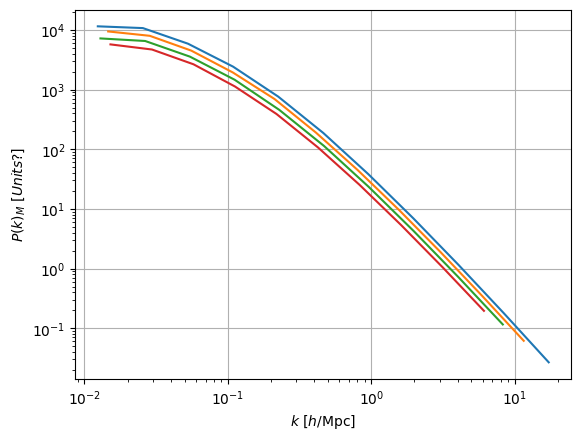

In [6]:
k_mags, k_maxs, k_mins, num_kbins, zShifts = ut.kSpecs_multi(TIMxEu, returnVal = 'all')
Pms = ut.CAMB_Pm_multi(k_mags, k_maxs, k_mins, num_kbins, zShifts )

#plot the matter power spectrum calculated by CAMB for each TIMxEuclid sub-survey.
[plt.loglog(ks,Pm) for (ks, Pm) in Pms]
plt.grid()
plt.xlabel(r'$k \ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k)_M \ [Units?]$')

In [7]:
kbin_edges_list, nEffs_list, transferAves_list = ut.nEffs_multi(TIMxEu, Pms)

Text(0, 0.5, '$N_{eff}(k)$')

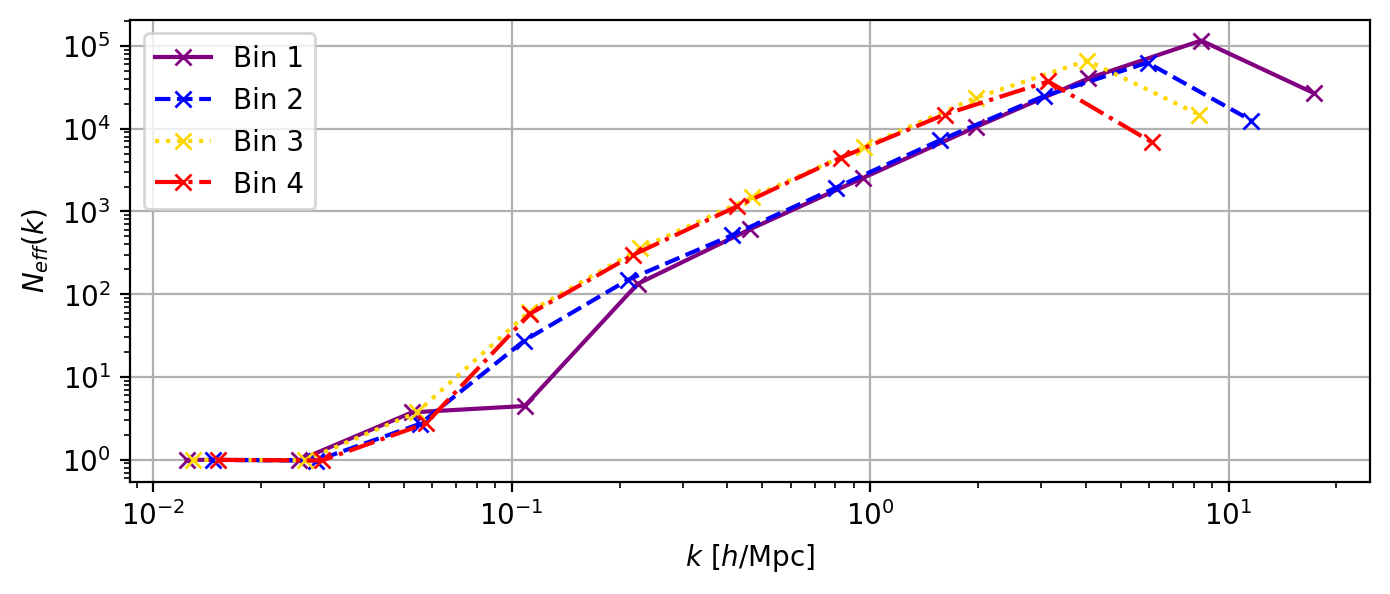

In [8]:
plt.figure(dpi = 200, figsize = (8,3))
[plt.loglog(Pms[i][0], nEffs_list[i], label = f'Bin {i+1}', color = colors[i], ls = linestyles[i], marker = 'x') 
                                                                    for i in range(len(nEffs_list))]
plt.grid()
plt.legend()

plt.xlabel(r'$k \ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$N_{eff}(k)$')

In [9]:
k_magsCAMB = k_mags

In [10]:
k_mags = [TIMxEu[i].k_mags for i in range(len(TIMxEu))]
windows = [TIMxEu[i].transferCoefs for i in range(len(TIMxEu))]
k_props = [TIMxEu[i].k_props for i in range(len(TIMxEu))]
window_avgs = transferAves_list #just renaming to match old plotting code.


In [11]:
[np.nonzero(k_mag.value - k_magCAMB) for k_mag, k_magCAMB in zip(k_mags, k_magsCAMB)] # Find indices where k_mag differs from k_magCAMB
#Should be empty arrays if k_mag and k_magCAMB are indeed identical.

[(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))]

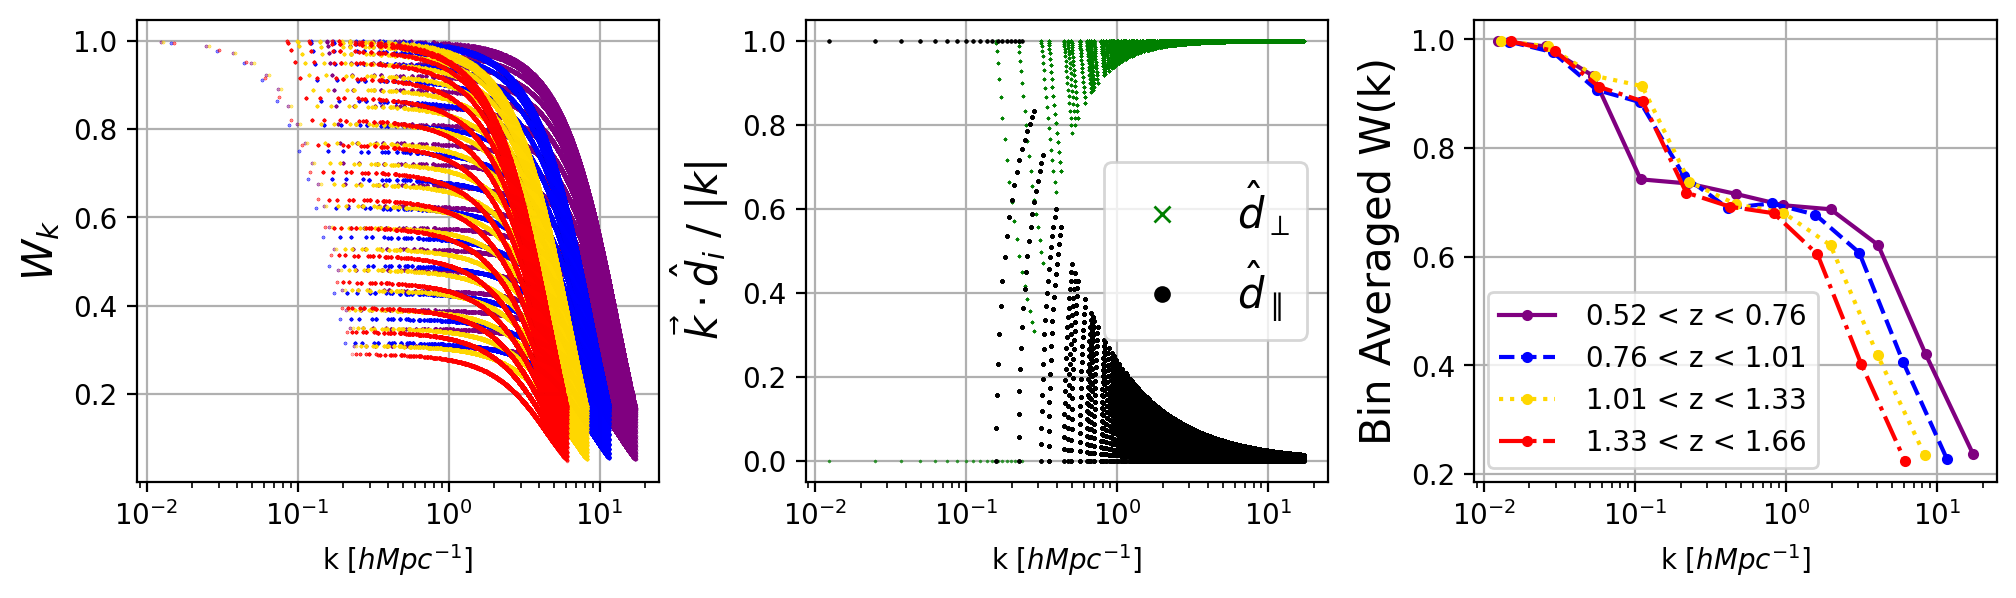

In [12]:
fig, (scatter, component, ave) = plt.subplots(1,3, figsize = (12,3), dpi = 200)#, sharex = True)

for i in range(len(k_mags)):
    scatter.semilogx(k_mags[i].flatten(), windows[i].flatten(), marker='.', \
    linestyle='None', label = f" {VanillaTIM[i].zBin.zFront:.2f} < z < {VanillaTIM[i].zBin.zBack:.2f}", markersize=.6, color = colors[i], alpha = .5)
scatter.grid()

for i in range(len(Pms)):
    ave.semilogx(Pms[i][0], window_avgs[i], label = f" {VanillaTIM[i].zBin.zFront:.2f} < z < {VanillaTIM[i].zBin.zBack:.2f}", marker='.', 
             color = colors[i], linestyle = linestyles[i] )
    
ave.grid()
ave.legend()
    
# making a plot for bin1
component.semilogx(k_mags[0].flatten(), (k_props[0][0] ** 2 + k_props[0][1] ** 2).flatten(), marker='x',
               linestyle='None', markersize=.6, alpha = 0.5, label = r'$\hat{d}_\perp$', color = 'green')
component.semilogx(k_mags[0].flatten(), k_props[0][2].flatten(), marker='.', linestyle='None', 
               markersize=1, label = r'$\hat{d}_{\parallel} $', color = 'black')
component.grid()
compLeg = component.legend(fontsize = 15, markerscale = 10)
for lh in compLeg.legend_handles:
    lh.set_alpha(1)

scatter.set_xlabel(r"k [$h Mpc^{-1}]$", size=10)
component.set_xlabel(r"k [$h Mpc^{-1}]$", size=10)
ave.set_xlabel(r"k [$h Mpc^{-1}]$", size=10)

component.set_ylabel(r'$ \vec{k} \cdot \hat{d}_{i}$ / $|k|$', fontsize = 15)
scatter.set_ylabel(r'$W_k$', fontsize = 15)
ave.set_ylabel('Bin Averaged W(k)', fontsize = 15)
fig.subplots_adjust(hspace=0, wspace=0.28)

In [13]:
bCII = bGal = 1.7
shotCIIs = [1.2e9,2.2e9,3e9,3e9]
fillFactor = 0.897

PxGTuples = [xBin.xCorr(PmTuple, bCII, bGal, shots, fillFactor, returnFull=True) 
    for xBin, PmTuple, shots in zip(TIMxEu, Pms, shotCIIs)] 
        #could easily add z dependence on the biases

In [14]:
#Assigning variables from PxGTuples to match my old plotting code for ease.

PxGs, VARx  = [tup[0] for tup in PxGTuples], [tup[1] for tup in PxGTuples]
x_shots, Plls = [tup[2] for tup in PxGTuples], [tup[3] for tup in PxGTuples]
NTIMs, ICiis = [tup[4] for tup in PxGTuples], [tup[5] for tup in PxGTuples]
nEffs = [tup[6] for tup in PxGTuples]

SNR_PxG = [PxG / np.sqrt(VARs)  for PxG, VARs in zip(PxGs, VARx)]

#sum the SNRs in each bin in quadrature so that we can report a "Total SNR per redshift bin"
quad_SNRs = [np.sqrt(np.sum(SNRs[~np.isnan(SNRs)]**2)) for SNRs in SNR_PxG]

#CAMB outputs lists of different ks for each bin so we can't sum them 'apples to apples.'
#So, we'll interpolate Cross powers, SNRs and noise values at matching ks across all bins.
aligned_PxGs, aligned_SNRs, aligned_x_noises = ut.SNR_interp_multi(Pms, PxGs, VARx, 3)

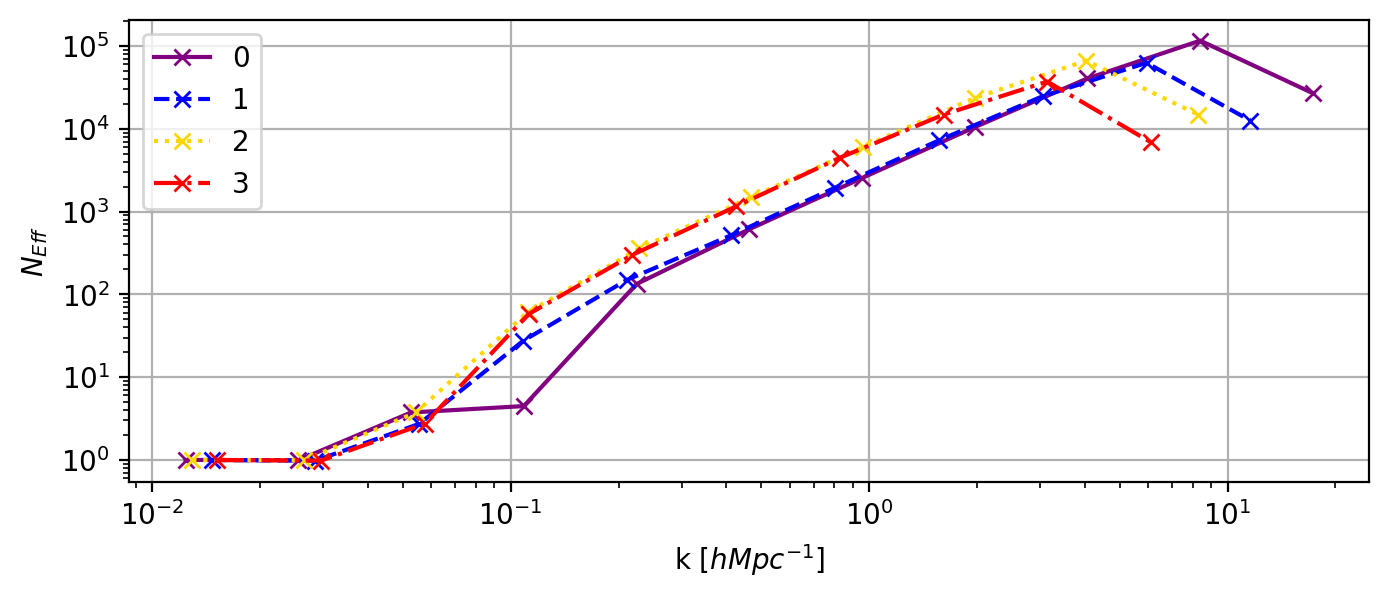

In [15]:
#[plt.loglog(ks, nEff) for (ks,_), nEff in zip(Pms, nEffs)]

plt.figure(dpi = 200, figsize = (8,3))
for i,((ks,_), nums, col) in enumerate(zip(Pms,nEffs, colors)):
    plt.loglog(ks,nums, color = col, linestyle = linestyles[i], marker = 'x',
               label = i)

plt.xlabel(r"k [$h Mpc^{-1}]$", size=10)
plt.ylabel(r'$N_{Eff}$')

plt.grid()
plt.legend()

Text(0, 0.5, '$Var(P_{x}) \\ [Units?]$')

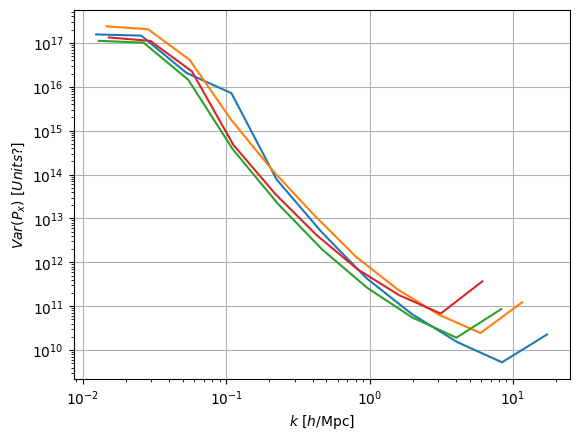

In [16]:
[plt.loglog(ks, Var) for (ks,_), Var in zip(Pms, VARx)]
plt.grid()
plt.xlabel(r'$k \ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$Var(P_{x}) \ [Units?]$')

#plt.ylim(1e8, 2e16)

C:\Users\juzz\AppData\Local\Temp\ipykernel_27280\2001186208.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in leg.legendHandles:


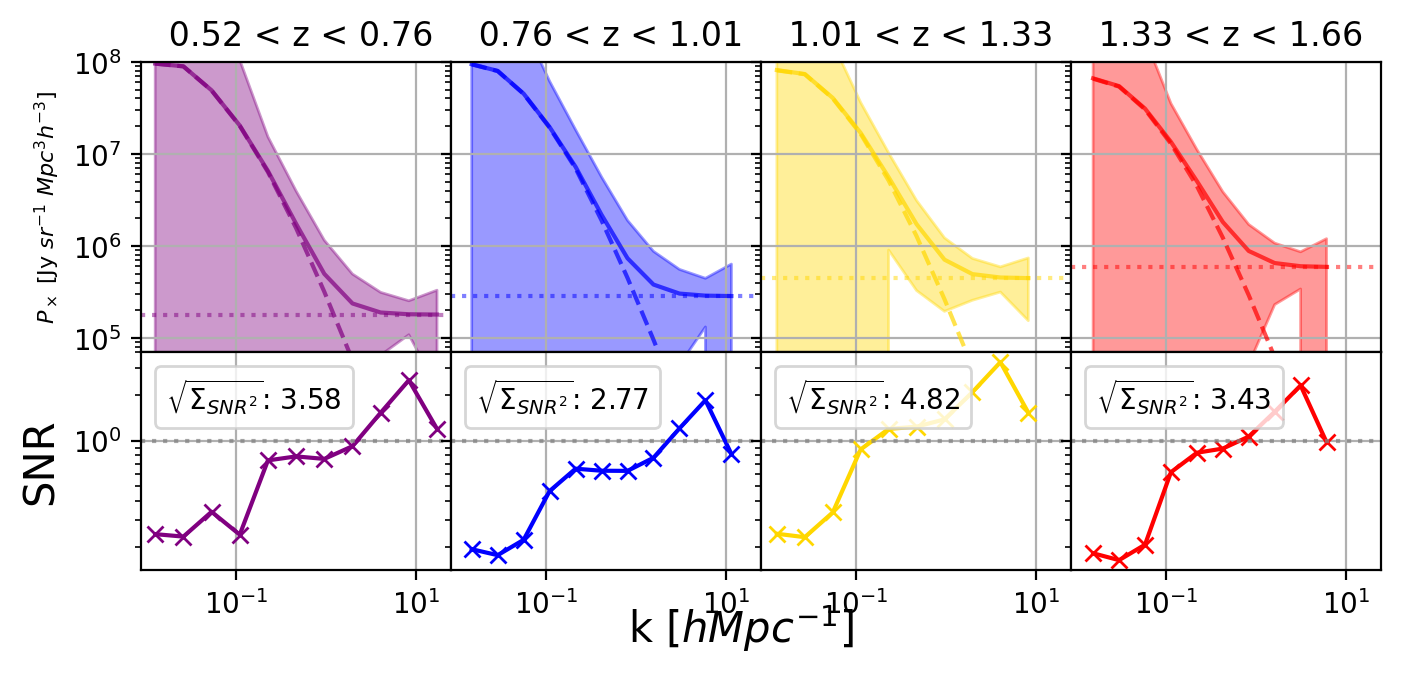

In [17]:
# Generate the "Power Rangers" plot.

fig, (power, SNR) = plt.subplots(2, 4, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [4,3]}, 
                                 figsize=(8, 3.3), dpi = 200)

#plot Cross power as a function of k for each z bin, as well as SNR(k).
for i, PxG in enumerate(PxGs):
    power[i].loglog(Pms[i][0], PxG - x_shots[i].value, color = colors[i], linestyle = '--', alpha = .7)
    power[i].loglog(Pms[i][0], PxG, color = colors[i], linestyle = '-', alpha = .7)
    power[i].axhline(x_shots[i].value, color = colors[i], linestyle = ':', alpha = .5)
    power[i].fill_between(Pms[i][0], PxG + np.sqrt(VARx[i]),
                   PxG - np.sqrt(VARx[i]), color = colors[i], alpha = .4)
    #power[i].set_title('Bin'+str(i+1))
    power[i].set_title(f" {VanillaTIM[i].zBin.zFront:.2f} < z < {VanillaTIM[i].zBin.zBack:.2f}")

    SNR[i].loglog(Pms[i][0], SNR_PxG[i], color = colors[i], marker = 'x', 
                label = r'$\sqrt{\Sigma_{SNR^2}}$: ' + str(np.around(quad_SNRs[i],2)))
    SNR[i].axhline(1, color = 'grey', ls = ":", alpha = .7)
    power[i].grid()
    SNR[i].grid()
    SNR[i].legend(fontsize = 7)
    #SNR[i].set_yticks(np.arange(0, 26, 4.0))
    leg = SNR[i].legend(prop={'size': 10}, handlelength=0, handletextpad=0, fancybox=True, loc = 'upper left')
    for item in leg.legendHandles:
        item.set_visible(False)

power[0].set_ylabel(r"$P_\times$ [Jy $sr^{-1}$ $Mpc^3 h^{-3}]$", size = 8)
power[0].set_ylim(7e4,1e8)

SNR[0].set_ylabel(r"SNR", size = 15)

fig.text(0.5, 0.001, r"k [$h Mpc^{-1}]$", size=15, ha='center')

fig.subplots_adjust(hspace=0, wspace=0)

plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':True})
plt.rcParams.update({'ytick.right':True})
plt.rcParams.update({'legend.frameon':False})
plt.rcParams.update({'lines.dashed_pattern':[5,3]})

plt.show()
plt.close()

In [18]:
import props_TIM2 as pTIM2
import props_SpaceTIM as pTIMS

reload(pTIM2)
reload(pTIMS)

TIM2 = pTIM2.subSurveys
TIM2xEu = [ut.LIMxGAL(TIM2Bin, EuBin, window = "Gaussian") for TIM2Bin, EuBin in zip(TIM2, EuMinimal)]

TIMSp = pTIMS.subSurveys
TIMSpxEu = [ut.LIMxGAL(TIMSpBin, EuBin, window = "Gaussian") for TIMSpBin, EuBin in zip(TIMSp, EuMinimal)]

k_mags2, k_maxs2, k_mins2, num_kbins2, zShifts2 = ut.kSpecs_multi(TIM2xEu, returnVal = 'all')
Pms2 = ut.CAMB_Pm_multi(k_mags2, k_maxs2, k_mins2, num_kbins2, zShifts2)

k_magsSp, k_maxsSp, k_minsSp, num_kbinsSp, zShiftsSp = ut.kSpecs_multi(TIMSpxEu, returnVal = 'all')
PmsSp = ut.CAMB_Pm_multi(k_magsSp, k_maxsSp, k_minsSp, num_kbinsSp, zShiftsSp)

Applying Gaussian windowing
sPar: 5.522480633096668 Mpc, sPerp: 0.43619382286947955, galPar: 3.451550395685418 Mpc
Applying Gaussian windowing
sPar: 6.285520716479786 Mpc, sPerp: 0.6468056600969666, galPar: 3.9284504477998663 Mpc
Applying Gaussian windowing
sPar: 5.291560807957791 Mpc, sPerp: 0.9122352696282233, galPar: 3.3072255049736192 Mpc
Applying Gaussian windowing
sPar: 5.856478551331577 Mpc, sPerp: 1.235020943475706, galPar: 3.6602990945822356 Mpc
Applying Gaussian windowing
sPar: 5.522480633096668 Mpc, sPerp: 0.43619382286947955, galPar: 3.451550395685418 Mpc
Applying Gaussian windowing
sPar: 6.285520716479786 Mpc, sPerp: 0.6468056600969666, galPar: 3.9284504477998663 Mpc
Applying Gaussian windowing
sPar: 5.291560807957791 Mpc, sPerp: 0.9122352696282233, galPar: 3.3072255049736192 Mpc
Applying Gaussian windowing
sPar: 5.856478551331577 Mpc, sPerp: 1.235020943475706, galPar: 3.6602990945822356 Mpc
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-

In [19]:
kbin_edges_list2, TIM2Numks, transferAves_list2 = ut.nEffs_multi(TIM2xEu, Pms2)
kbin_edges_listSp, spaceNumks, transferAves_listSp = ut.nEffs_multi(TIMSpxEu, PmsSp)


k_mags2 = [TIM2xEu[i].k_mags for i in range(len(TIM2xEu))]
windows2 = [TIM2xEu[i].transferCoefs for i in range(len(TIM2xEu))]
k_props2 = [TIM2xEu[i].k_props for i in range(len(TIM2xEu))]
window_avgs2 = transferAves_list2 

k_magsSp = [TIMSpxEu[i].k_mags for i in range(len(TIMSpxEu))]
windowsSp = [TIMSpxEu[i].transferCoefs for i in range(len(TIMSpxEu))]
k_propsSp = [TIMSpxEu[i].k_props for i in range(len(TIMSpxEu))]
window_avgsSp = transferAves_listSp


In [20]:
PxGTuples2 = [xBin.xCorr(PmTuple, bCII, bGal, shots, fillFactor, returnFull=True) 
    for xBin, PmTuple, shots in zip(TIM2xEu, Pms2, shotCIIs)] 

PxGs2, VARx2  = [tup[0] for tup in PxGTuples2], [tup[1] for tup in PxGTuples2]
x_shots2, Plls2 = [tup[2] for tup in PxGTuples2], [tup[3] for tup in PxGTuples2]
NTIMs2, ICiis2 = [tup[4] for tup in PxGTuples2], [tup[5] for tup in PxGTuples2]
SNR_PxG2 = [PxG / np.sqrt(VARs)  for PxG, VARs in zip(PxGs2, VARx2)]


PxGTuplesSp = [xBin.xCorr(PmTuple, bCII, bGal, shots, fillFactor, returnFull=True) 
    for xBin, PmTuple, shots in zip(TIMSpxEu, PmsSp, shotCIIs)] 

PxGsSp, VARxSp  = [tup[0] for tup in PxGTuplesSp], [tup[1] for tup in PxGTuplesSp]
x_shotsSp, PllsSp = [tup[2] for tup in PxGTuplesSp], [tup[3] for tup in PxGTuplesSp]
NTIMsSp, ICiisSp = [tup[4] for tup in PxGTuplesSp], [tup[5] for tup in PxGTuplesSp]
SNR_PxGSp = [PxG / np.sqrt(VARs)  for PxG, VARs in zip(PxGsSp, VARxSp)]

In [21]:
ICII_Vars = [(bCII*bGal*Ps)**2/VARs for (_,Ps), VARs in zip(Pms, VARx)] # Calculate the ICII Variances
ICIISigsTot = np.asarray( [np.sqrt(1/np.sum(IVar)) for IVar in ICII_Vars] ) # Calculate the ICII Signal-to-Noise Ratios

ICII_Vars2 =  [(bCII*bGal*Ps)**2/VARs for (_,Ps), VARs in zip(Pms2, VARx2)] 
TIM2Sig = np.asarray( [np.sqrt(1/np.sum(IVar)) for IVar in ICII_Vars2] )

ICII_VarsSp = [(bCII*bGal*Ps)**2/VARs for (_,Ps), VARs in zip(PmsSp, VARxSp)] 
spaceSig = np.asarray( [np.sqrt(1/np.sum(IVar)) for IVar in ICII_VarsSp] )

In [22]:
ICIISigsTot

array([2282.89691495, 3129.00159605, 2143.13849781, 3247.78309177])

In [23]:
def modelPx(model_params):
    modelP = model_params[:,7]
    modelShot = model_params[:,8]
    return [xPow*Pm + shot for xPow, (_,Pm), shot in zip(modelP, Pms, modelShot)]
def modelICII(model_params):
    return model_params[:,0], model_params[:,1]
preface = './model_Params_from_simim/juzz_data_model_lcii_'
ICIIPreface = './model_Params_from_simim/juzz_icii_history_model_lcii_'


pessMax_params = modelPx(np.loadtxt(preface + 'sighigh.npy', delimiter=','))
pessMin_params = modelPx(np.loadtxt(preface + 'sfrumint.npy', delimiter=','))
optiMax_params = modelPx(np.loadtxt(preface + 'p19.npy', delimiter=','))
optiMin_params = modelPx(np.loadtxt(preface + 'h17um.npy', delimiter=','))
g12 = modelPx(np.loadtxt(preface + 'g12.npy', delimiter=','))
p19 = modelPx(np.loadtxt(preface + 'p19.npy', delimiter=','))
Y22 = modelPx(np.loadtxt(preface + 'Y22.npy', delimiter=','))

pessMax_ICII = modelICII(np.loadtxt(ICIIPreface + 'sighigh.csv', delimiter=','))
pessMin_ICII = modelICII(np.loadtxt(ICIIPreface + 'sfrumint.csv', delimiter=','))
optiMax_ICII = modelICII(np.loadtxt(ICIIPreface + 'p19.csv', delimiter=','))
optiMin_ICII = modelICII(np.loadtxt(ICIIPreface + 'h17um.csv', delimiter=','))
g12_ICII = modelICII(np.loadtxt(ICIIPreface + 'g12.csv', delimiter=','))
p19_ICII = modelICII(np.loadtxt(ICIIPreface + 'p19.csv', delimiter=','))
Y22_ICII = modelICII(np.loadtxt(ICIIPreface + 'Y22.csv', delimiter=','))

simimFiducial = modelPx(np.loadtxt(preface[:-1]+'.npy', delimiter=','))
simimICII = modelICII(np.loadtxt(ICIIPreface[:-1]+'.csv', delimiter=','))

In [24]:
first = True

for modelFile in os.listdir('./model_Params_from_simim'):
    if 'icii_history' in modelFile:
        if 'g12' in modelFile: continue
        model = np.loadtxt('./model_Params_from_simim/'+modelFile, delimiter=',')
        if first:
            modelStack = model[:,1]
            first = False
        else: modelStack = np.vstack((modelStack, model[:, 1]))
            
IciiModelMin = [modelStack[:,i][~np.isnan(modelStack[:,i])].min() for i in np.arange(len(modelStack[0,:]))]
IciiModelMax = [modelStack[:,i][~np.isnan(modelStack[:,i])].max() for i in np.arange(len(modelStack[0,:]))]

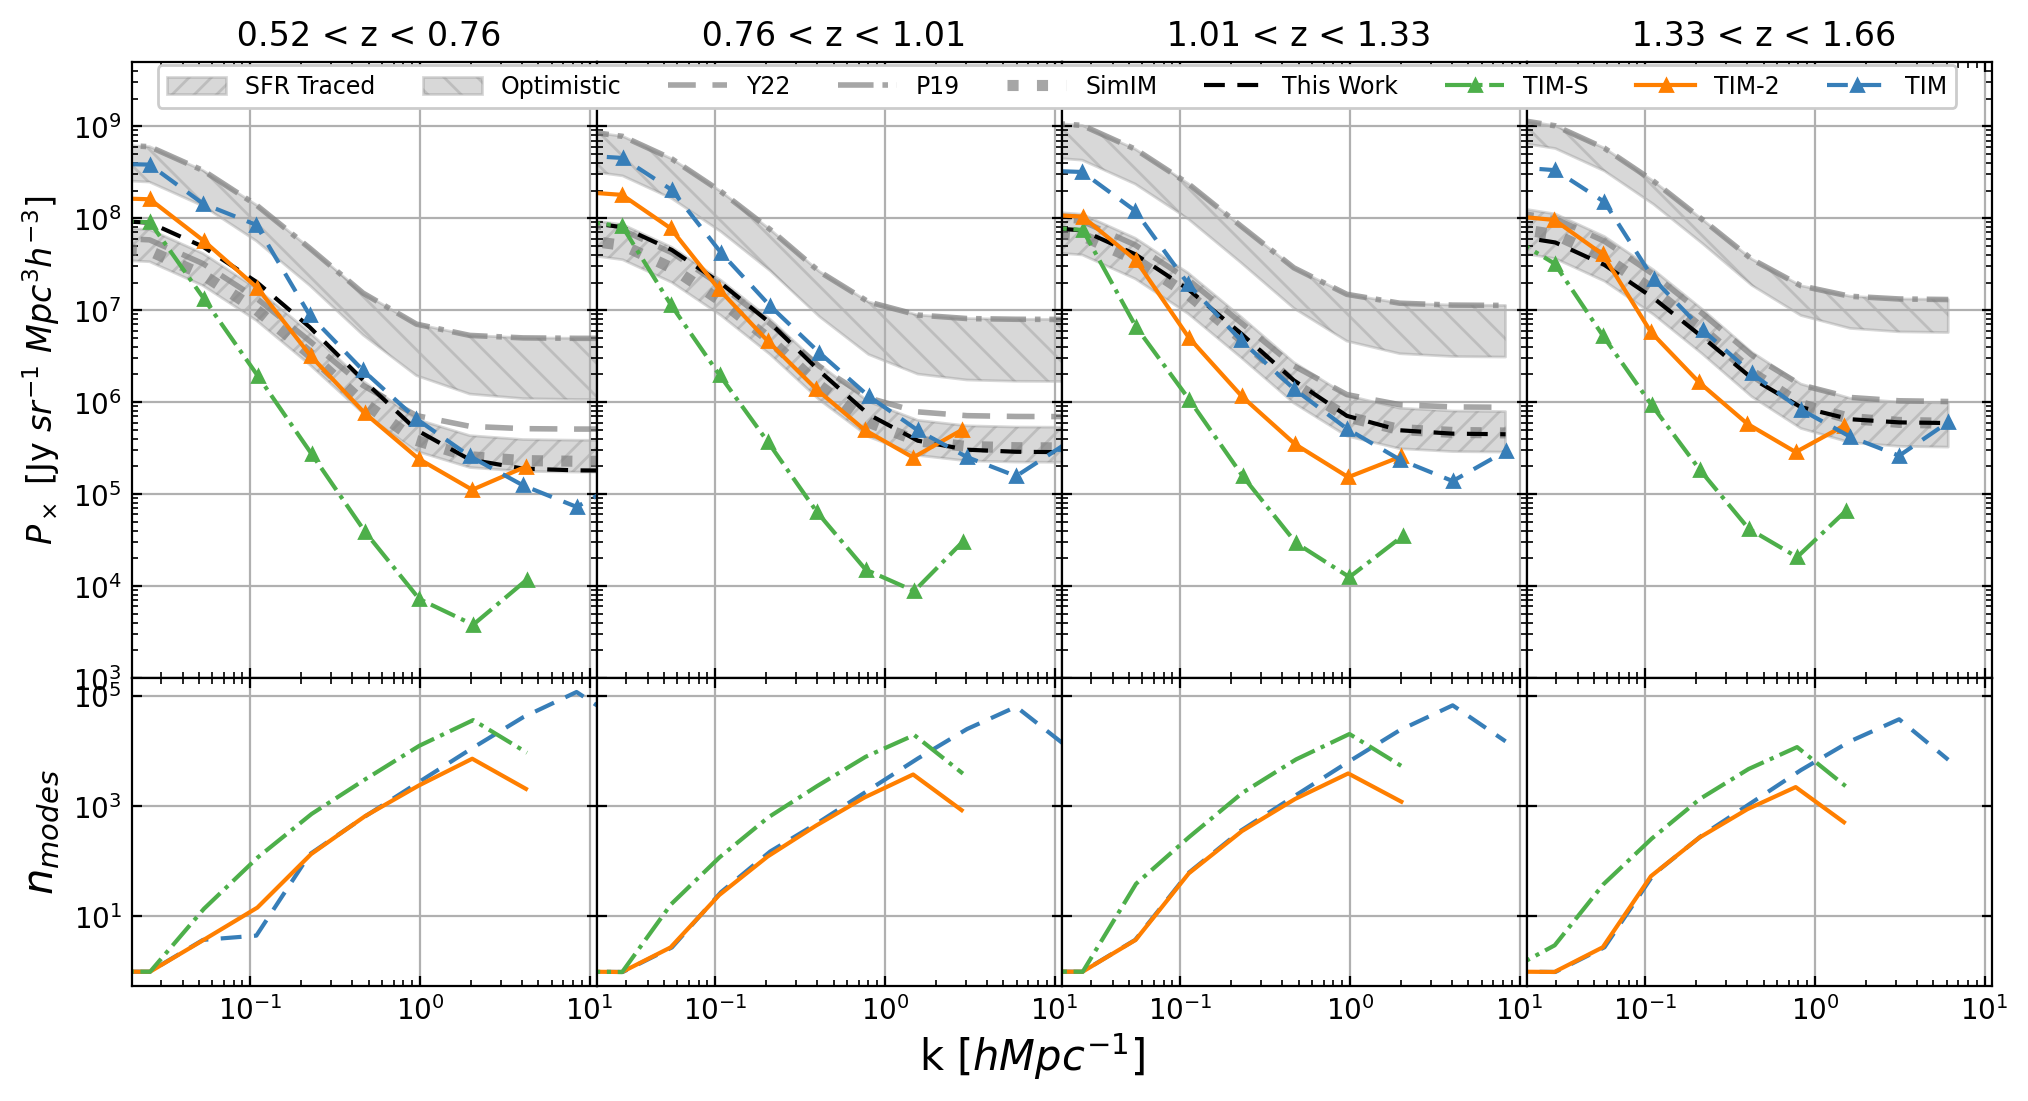

In [25]:
fig, (plots, kplots) = plt.subplots(2,4, figsize = (12, 6), dpi = 200, sharey = 'row', sharex = True,
                                    gridspec_kw={'height_ratios': [4,2]})

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

TIMcolor = CB_color_cycle[0]
TIM2color = CB_color_cycle[1]
TIMScolor = CB_color_cycle[2]

    
for i in np.arange(0,4):
    
    plots[i].fill_between(Pms[i][0], pessMax_params[i], pessMin_params[i], color = 'grey', alpha = 0.3, hatch = '///',
                          label = 'SFR Traced')
    plots[i].fill_between(Pms[i][0], optiMax_params[i], optiMin_params[i], color = 'grey', alpha = 0.3, hatch = '\\\\',
                          label = 'Optimistic')
    
    plots[i].loglog(Pms[i][0], Y22[i], label = 'Y22', ls = '--', lw = 2, color = 'grey', alpha = 0.7)
    plots[i].loglog(Pms[i][0], p19[i], label = 'P19', ls = '-.', lw = 2, color = 'grey', alpha = 0.7)    
    plots[i].loglog(Pms[i][0], simimFiducial[i], color = 'grey', label = 'SimIM', ls = ':', lw = 4, alpha = 0.7)
    plots[i].loglog(Pms[i][0], PxGs[i], color = 'k', linestyle = '--', label = 'This Work')
    
    plots[i].loglog(PmsSp[i][0], np.sqrt(VARxSp[i]), marker = '^', label = 'TIM-S', ms = 4,
                    color = TIMScolor, ls = '-.')
    plots[i].loglog(Pms2[i][0], np.sqrt(VARx2[i]), marker = '^', label = 'TIM-2', ms = 4,
                    color = TIM2color, ls = '-')

    plots[i].grid()
    kplots[i].grid()
    
    plots[i].set_title(f" {VanillaTIM[i].zBin.zFront:.2f} < z < {VanillaTIM[i].zBin.zBack:.2f}")
    kplots[i].loglog(Pms[i][0], nEffs[i], color = TIMcolor, marker = '', ls = '--')
    kplots[i].loglog(Pms2[i][0], TIM2Numks[i], color = TIM2color, marker = '', ms = 10, ls = '-')
    kplots[i].loglog(PmsSp[i][0], spaceNumks[i], color = TIMScolor, marker = '', ls = '-.')
    

[plots[i].loglog(ks, np.sqrt(VARs), ls = '--', marker = '^', color = TIMcolor, label = 'TIM', ms = 4) 
         for i, (VARs, (ks,_)) in enumerate(zip(VARx, Pms))]


fig.text(0.5, 0.04, r"k [$h Mpc^{-1}]$", size=15, ha='center')
plots[0].set_ylabel(r"$P_\times$ [Jy $sr^{-1}$ $Mpc^3 h^{-3}]$", size = 12)
kplots[0].set_ylabel(r"$n_{modes}$", size = 15)
plots[2].set_xlim(2e-2,1.1e1)
plots[0].set_ylim(1e3,5e9)

plots[3].legend(loc='center right', bbox_to_anchor=(0.95, 0.96), frameon = True, fontsize = 8.5,
      ncol=9, fancybox=True, shadow=False, framealpha = 1, handlelength=2.5)
#plots[0].legend(fontsize = 9)
#fig.subplots_adjust(hspace=0., wspace=0.06)
fig.subplots_adjust(hspace=0., wspace=0.00)

In [26]:
agesTIM = [cosmo.age(subSurv.LIM.zBin.zCenter).value for subSurv in TIMxEu]
agesTIM2 = [cosmo.age(subSurv.LIM.zBin.zCenter).value for subSurv in TIM2xEu]
agesTIMSp = [cosmo.age(subSurv.LIM.zBin.zCenter).value for subSurv in TIMSpxEu]


binExtents = [((subSurv.LIM.zBin.zBack) - (subSurv.LIM.zBin.zFront))/2 for subSurv in TIMxEu]
binExtents = np.asarray(binExtents)
bin_zs = [subSurv.LIM.zBin.zCenter.value for subSurv in TIMxEu]


In [27]:
#from E_lines import CII

L0=8.3 * 10**6 * u.Lsun * u.yr / u.Msun
SFu = (u.M_sun/u.yr/u.Mpc**3)

def ItoSFRD(I):
    if not hasattr(I, "unit"):
        I = I * u.Jy
    SFRD = 4*np.pi*cosmo.H0*l.CII.nu*I / (c.c*L0)
    return SFRD.to(u.M_sun/u.yr/u.Mpc**3).value

def SFRDtoI(SFRD):
    if not hasattr(SFRD, "unit"):
        SFRD = SFRD * SFu

    I = c.c * L0 * SFRD / (4*np.pi*cosmo.H0*l.CII.nu)
    return I.to(u.Jy).value

ItoSFRD(10**5*u.Jy), SFRDtoI(1.6*u.M_sun/u.yr/u.Mpc**3)

(1.6152921777270706, 99053.28720475892)

In [28]:
zgrid = np.linspace(0,30,3001)
agegrid = cosmo.age(zgrid).value
def transform(z):
    return np.interp(z, zgrid, agegrid)
def itransform(age):
    return np.interp(age, agegrid[::-1], zgrid[::-1])

def setup_history(ax,zlim=[5,0],zticks=[0,1,2,5],zticklabels=None,timeticks=np.array([1,3,5,7,9,11,13]),timeticklabels=None):
    if zticklabels is None:
        zticklabels = zticks
    if timeticklabels is None:
        timeticklabels = timeticks
    ax.set_xscale('function',functions=(transform,itransform))
    ax.set(xlim=zlim, xlabel='Age of Universe [Gyr]', xticks=itransform(timeticks), xticklabels=timeticklabels)
    ax.set(yscale='log')
    
    ax2 = ax.twiny()
    ax2.set_xscale('function',functions=(transform,itransform))
    ax2.set(xlim=zlim,xlabel='Redshift',xticks=zticks,xticklabels=zticklabels)

    return ax, ax2

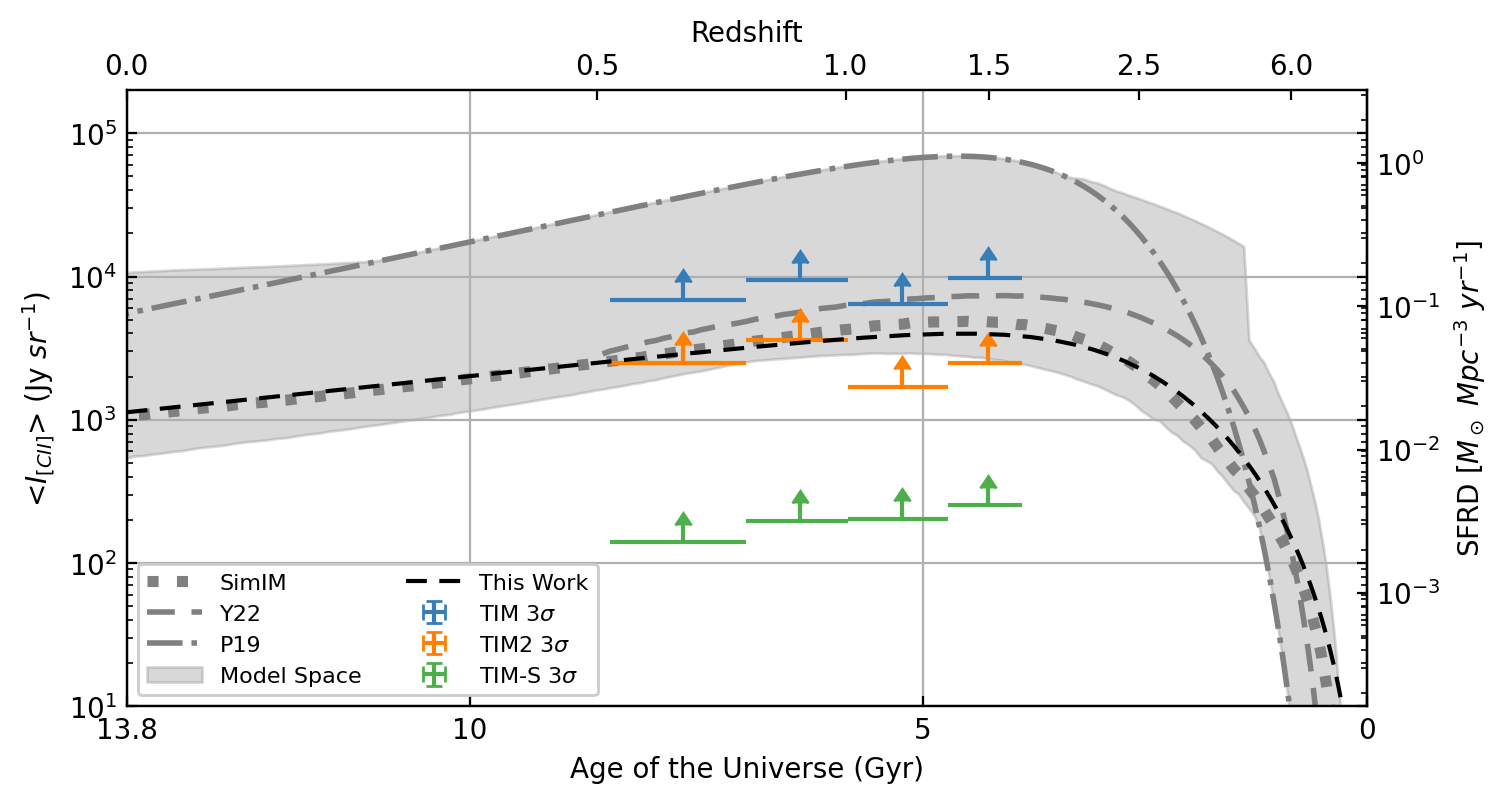

In [29]:

fig, ax = plt.subplots(dpi = 200, figsize = [8,4])

ax.semilogy(simimICII[0], simimICII[1], color = 'grey', label = 'SimIM', ls = ':', lw = 4)
ax.semilogy(Y22_ICII[0], Y22_ICII[1], label = 'Y22', ls = '--', lw = 2, color = 'grey')
ax.semilogy(p19_ICII[0], p19_ICII[1], label = 'P19', ls = '-.', lw = 2, color = 'grey')

ax.fill_between(pessMax_ICII[0], IciiModelMax, IciiModelMin, color = 'grey', alpha = 0.3,
                          label = 'Model Space')

ax.errorbar(bin_zs, 3*ICIISigsTot, xerr=binExtents, yerr= ICIISigsTot, lolims=True, 
             label = 'TIM $3\sigma$', color = TIMcolor, ls = '')
ax.errorbar(bin_zs, 3*TIM2Sig, xerr=binExtents, yerr= TIM2Sig, lolims=True, 
             label = 'TIM2 $3\sigma$', color = TIM2color, ls = '')
ax.errorbar(bin_zs, 3*spaceSig, xerr=binExtents, yerr= spaceSig, lolims=True, 
             label = 'TIM-S $3\sigma$', color = TIMScolor, ls = '')

ax.set_xlabel("Age of the Universe (Gyr)")
ax.set_ylim(10, 2e5)
ax.set_xlim(0,13)


zticks = np.array([0,0.5,1.0,1.5,2.5,6])
timeticks = np.array([0.0,5,10,cosmo.age(0).value])
timeticklabels = ['0','5','10','{:.1f}'.format(cosmo.age(0).value)]
ax, ax_time = setup_history(ax,zlim=(100,0),zticks=zticks,zticklabels=None,timeticks=timeticks,timeticklabels=timeticklabels)                   

zList = np.linspace(0,13,100)
SFRDList = ut.MD_sfrd(zList)
IList = ut.I_Bracks25(zList, SFRDList, l.CII.nu)
ax.semilogy(zList, IList, color = 'k', ls = '--', label = 'This Work')

ax2 = ax.secondary_yaxis('right', functions=(ItoSFRD, SFRDtoI))
ax2.set_ylabel(r'SFRD [$M_\odot$ $Mpc^{-3}$ $yr^{-1}]$')


ax.set_xlabel("Age of the Universe (Gyr)")
ax.set_ylabel(r"<$I_{[CII]}$> (Jy $sr^{-1}$)")
#ax.legend(loc='center right', frameon = True, fontsize = 6,
#      ncol=8, fancybox=True, shadow=False, bbox_to_anchor=(0.98, 0.95), handlelength=2.5)
ax.legend(ncol = 2, fontsize = 8, handlelength=2.5,frameon = True, framealpha = 1)
ax.grid()


In [ ]:
def SNRasArea_Galcross(xSurv, areas, bCII = 1.7, bGal =1.7, shotCII = shotCIIs[2], fillFactor = 0.897): #using bracks25 params as default

    SNRs = []
    for area in areas:
        #EuMinimal = Eu.subSurveys
        #TIMxEu = [ut.LIMxGAL(TIMBin, EuBin, window = "Gaussian") for TIMBin, EuBin in zip(VanillaTIM, EuMinimal)]

        xSurv.Az = np.sqrt(area)
        xSurv.El = np.sqrt(area)

        k_mags3, k_maxs3, k_mins3, num_kbins3, zShifts3 = ut.kSpecs_single(xSurv, returnVal = 'all')
        Pm3 = ut.CAMB_Pm_single(k_mags3, k_maxs3, k_mins3, num_kbins3, [zShifts3] )
        print(Pm3)
        PxG3, VAR3, xShot3 = xSurv.xCorr(Pm3, bCII, bGal, shotCII, fillFactor, returnFull=False)
        SNR_PxG3 = PxG3 / np.sqrt(VAR3)
        quad_SNR3 = np.sqrt(np.sum(SNR_PxG3[~np.isnan(SNR_PxG3)]**2))
        SNRs.append(quad_SNR3)
    SNRs = np.asarray(SNRs)
    return areas, SNRs

In [33]:
areas, SNRs = SNRasArea_Galcross(TIMxEu[2], np.linspace(1, 100, 100))

TypeError: 'Quantity' object with a scalar value has no len()